# Installing Packages

In [0]:
!pip install --no-cache-dir -r requirements.txt

# Imports
Importing necessary packages and modules

In [0]:
%matplotlib inline

import random
import matplotlib.pyplot as plt

from tensornet.data.datasets import TinyImageNet
from tensornet.model import ResNet18
from tensornet.model.utils.loss import cross_entropy_loss
from tensornet.model.utils.optimizers import sgd
from tensornet.engine.ops.lr_scheduler import reduce_lr_on_plateau
from tensornet.utils import initialize_cuda, plot_metric

## Set Seed and Get GPU Availability

In [0]:
# Initialize CUDA and set random seed
cuda, device = initialize_cuda(1)

GPU Available? True


## Download Dataset

Importing the TinyImagenet class to download dataset and create data loader

In [0]:
dataset = TinyImageNet(
    train_batch_size=128,
    val_batch_size=128,
    cuda=cuda,
    num_workers=16,
    horizontal_flip_prob=0.3,
    vertical_flip_prob=0.1,
    rotate_degree=10,
    cutout_prob=0.3,
    cutout_dim=(16, 16),
)

Files already downloaded.
Files already downloaded.
Files already downloaded.


## Data Visualization

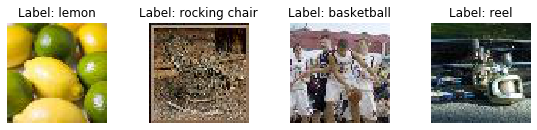

In [0]:
# Fetch data
classes = dataset.classes

# Set number of images to display
num_images = 4

# Display images with labels
fig, axs = plt.subplots(1, 4, figsize=(8, 8))
fig.tight_layout()

for i in range(num_images):
    idx = random.randint(0, len(dataset.val_data))
    axs[i].axis('off')
    axs[i].set_title(f'Label: {classes[dataset.val_data[idx][1]].split(",")[0]}')
    axs[i].imshow(dataset.unnormalize(dataset.val_data[idx][0], transpose=True))

## Training and Validation Dataloaders
This is the final step in data preparation. It sets the dataloader arguments and then creates the dataloader

In [0]:
# Create train data loader
train_loader = dataset.loader(train=True)

# Create val data loader
val_loader = dataset.loader(train=False)

# Model Architecture and Summary

In [0]:
model = ResNet18(num_classes=len(dataset.classes)).to(device)
model.summary(dataset.image_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
            Conv2d-3           [-1, 64, 64, 64]          36,864
       BatchNorm2d-4           [-1, 64, 64, 64]             128
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
        BasicBlock-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
           Conv2d-10           [-1, 64, 64, 64]          36,864
      BatchNorm2d-11           [-1, 64, 64, 64]             128
       BasicBlock-12           [-1, 64, 64, 64]               0
           Conv2d-13          [-1, 128, 32, 32]          73,728
      BatchNorm2d-14          [-1, 128,

# Model Training and Validation

In [0]:
optimizer = sgd(model, learning_rate=0.01, momentum=0.9)  # Create optimizer
criterion = cross_entropy_loss()  # Create loss function

In [0]:
epochs = 50

# Setup Reduce LR on Plateau
scheduler = reduce_lr_on_plateau(optimizer, patience=2, verbose=True, min_lr=1e-6)

# Model Training
model.fit(
    train_loader, optimizer, criterion, device=device, epochs=epochs,
    val_loader=val_loader, callbacks=[scheduler]
)

Epoch 1:
602/602 [========] - 149s 247ms/step - loss: 4.4573 - accuracy: 4.7045
Validation set: Average loss: 0.0331, Accuracy: 11.21%

Epoch 2:
602/602 [========] - 148s 247ms/step - loss: 3.6814 - accuracy: 10.5993
Validation set: Average loss: 0.0295, Accuracy: 16.54%

Epoch 3:
602/602 [========] - 148s 246ms/step - loss: 3.2787 - accuracy: 14.9748
Validation set: Average loss: 0.0278, Accuracy: 20.88%

Epoch 4:
602/602 [========] - 148s 246ms/step - loss: 2.9940 - accuracy: 18.5150
Validation set: Average loss: 0.0251, Accuracy: 27.20%

Epoch 5:
602/602 [========] - 148s 246ms/step - loss: 2.7735 - accuracy: 21.4928
Validation set: Average loss: 0.0221, Accuracy: 33.30%

Epoch 6:
602/602 [========] - 148s 245ms/step - loss: 2.5921 - accuracy: 24.1308
Validation set: Average loss: 0.0211, Accuracy: 35.80%

Epoch 7:
602/602 [========] - 148s 246ms/step - loss: 2.4434 - accuracy: 26.4772
Validation set: Average loss: 0.0210, Accuracy: 37.10%

Epoch 8:
602/602 [========] - 148s 246ms/s

# Plotting Results

Plot changes in validation accuracy

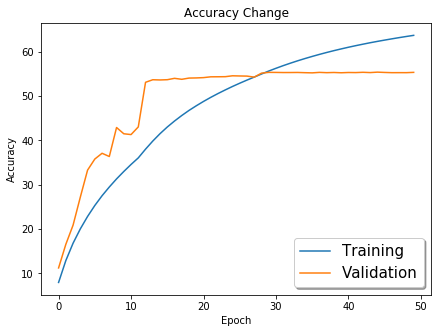

In [0]:
plot_metric({
    'Training': model.learner.train_accuracies,
    'Validation': model.learner.val_accuracies
}, 'Accuracy')